# Analysis of IMDB Data

We will analyze a subset of IMDB's actors, genres, movie actors, and movie ratings data. This dataset comes to us from Kaggle (https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset) although we have taken steps to pull this data into a publis s3 bucket: 

* s3://cis9760-lecture9-movieanalysis/name.basics.tsv ---> (actors)
* s3://cis9760-lecture9-movieanalysis/title.basics.tsv ---> (genres)
* s3://cis9760-lecture9-movieanalysis/title.principals.tsv ---> (movie actors)
* s3://cis9760-lecture9-movieanalysis/title.ratings.tsv ---> (movie ratings)

# Content

**<br />name.basics.tsv.gz – Contains the following information for names:**
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />primaryName (string)– name by which the person is most often credited.
<br />birthYear – in YYYY format.
<br />deathYear – in YYYY format if applicable, else .
<br />primaryProfession (array of strings)– the top-3 professions of the person.
<br />knownForTitles (array of tconsts) – titles the person is known for.
<br/><br/>
**<br />title.basics.tsv.gz - Contains the following information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc).
<br />primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release.
<br />originalTitle (string) - original title, in the original language.
<br />isAdult (boolean) - 0: non-adult title; 1: adult title.
<br />startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
<br />endYear (YYYY) – TV Series end year. for all other title types.
<br />runtimeMinutes – primary runtime of the title, in minutes.
<br />genres (string array) – includes up to three genres associated with the title.
<br/><br/>
**<br />title.principals.tsv – Contains the principal cast/crew for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />ordering (integer) – a number to uniquely identify rows for a given titleId.
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />category (string) - the category of job that person was in.
<br />job (string) - the specific job title if applicable, else.
<br />characters (string) - the name of the character played if applicable, else.
<br/><br/>
**<br />title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />averageRating – weighted average of all the individual user ratings.
<br />numVotes - number of votes the title has received.

# PART 1 - Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1669182411992_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
jmespath                   0.10.0   
joblib                     0.16.0   
lxml                       4.5.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
tqdm                       4.48.2   
wheel                      0.29.0   
windmill                   1.6

Let's install the necessary packages here

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ab/8f/8dbe2d4efc4c0b08ec67d6efb7cc31fbfd688c80afad85f65980633b0d37/kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_

Now, import the installed packages from the previous block below.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import approx_count_distinct, avg, collect_set, countDistinct, count, first, last, max, min, col,split,explode

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

Load all data from S3 into a Spark dataframe object 

In [4]:
actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/name.basics.tsv', sep=r'\t', header=True)
genres = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.basics.tsv', sep=r'\t', header=True)
movie_actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.principals.tsv', sep=r'\t', header=True)
movie_ratings = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.ratings.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Actors

Display the schema below:

In [5]:
actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

Display the first 5 rows with the following columns:

* `primaryName`
* `birthYear`
* `deathYear`
* `knownForTitles`

In [6]:
actors.select("primaryName","birthYear","deathYear","knownForTitles").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+---------+--------------------+
|    primaryName|birthYear|deathYear|      knownForTitles|
+---------------+---------+---------+--------------------+
|   Fred Astaire|     1899|     1987|tt0050419,tt00531...|
|  Lauren Bacall|     1924|     2014|tt0071877,tt01170...|
|Brigitte Bardot|     1934|       \N|tt0054452,tt00491...|
|   John Belushi|     1949|     1982|tt0077975,tt00725...|
| Ingmar Bergman|     1918|     2007|tt0069467,tt00509...|
+---------------+---------+---------+--------------------+
only showing top 5 rows

## Genres

Display the first 10 rows with the following columns:
    
* `titleType`
* `primaryTitle`
* `genres`

In [7]:
genres.select("titleType", "primaryTitle", "genres").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------------------+
|titleType|        primaryTitle|              genres|
+---------+--------------------+--------------------+
|    short|          Carmencita|   Documentary,Short|
|    short|Le clown et ses c...|     Animation,Short|
|    short|      Pauvre Pierrot|Animation,Comedy,...|
|    short|         Un bon bock|     Animation,Short|
|    short|    Blacksmith Scene|        Comedy,Short|
|    short|   Chinese Opium Den|               Short|
|    short|Corbett and Court...|         Short,Sport|
|    short|Edison Kinetoscop...|   Documentary,Short|
|    movie|          Miss Jerry|             Romance|
|    short| Exiting the Factory|   Documentary,Short|
+---------+--------------------+--------------------+
only showing top 10 rows

Display the unique categories below:

In [8]:
genres.select('titleType').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|       movie|
|   videoGame|
|   tvSpecial|
|       video|
|     tvMovie|
|   tvEpisode|
|     tvShort|
|       short|
+------------+

Display the schema below:

In [9]:
genres.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

## Movie Actors

Display the schema below:

In [10]:
movie_actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

Display the first 10 rows below

In [11]:
movie_actors.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

## Movie Ratings

Display the schema below:

In [12]:
movie_ratings.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)

Display the first 10 rows in a descending order by the number of votes

In [13]:
movie_ratings.orderBy(col('numVotes').desc()).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt7430722|          6.8|    9999|
|tt4445154|          8.1|    9997|
|tt2229907|          6.3|    9996|
|tt0294097|          8.0|    9994|
|tt0264734|          6.5|    9993|
|tt8860450|          6.3|    9991|
|tt2032572|          5.2|    9991|
|tt7201150|          8.5|     999|
|tt7508752|          7.9|     999|
|tt4082482|          6.8|     999|
+---------+-------------+--------+
only showing top 10 rows

# Overview of Data

Display the number of rows and columns in each dataFrame object.

In [14]:
actors_cols = len(actors.columns)
print(f"Number of columns in Actors table: {actors_cols}")
actors_rows = actors.count()
print(f"Number of rows in Actors table: {actors_rows}", "\n")

genres_cols = len(genres.columns)
print(f"Number of columns in Genres table: {genres_cols}")
genres_rows = genres.count()
print(f"Number of rows in Genres table: {genres_rows}", "\n")

movieactors_cols = len(movie_actors.columns)
print(f"Number of columns in Movie Actors table: {movieactors_cols}")
movieactors_rows = movie_actors.count()
print(f"Number of rows in Movie Actors table: {movieactors_rows}", "\n")

movieratings_cols = len(movie_ratings.columns)
print(f"Number of columns in Movie Ratings table: {movieratings_cols}")
movieratings_rows = movie_ratings.count()
print(f"Number of rows in Movie Ratings table: {movieratings_rows}", "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Actors table: 6
Number of rows in Actors table: 9706922 

Number of columns in Genres table: 9
Number of rows in Genres table: 6321302 

Number of columns in Movie Actors table: 6
Number of rows in Movie Actors table: 36468817 

Number of columns in Movie Ratings table: 3
Number of rows in Movie Ratings table: 993153

# PART 2 - Analyzing Genres

Let's now answer this question: how many unique genres are represented in this dataset?

Essentially, we have the genres per movie as a list - this is useful to quickly see what each movie might be represented as but it is difficult to easily answer questions such as:

* How many movies are categorized as Comedy, for instance?
* What are the top 20 most popular genres available?

## Association Table

We need to "break out" these genres from the tconst? One common approach to take is to build an association table mapping a single tconst multiple times to each distinct genre.

For instance, given the following:


| tconst   | titleType  |genres |
|----------|------------|-------|
| abcd123  | XXX        |a,b,c  |

We would like to derive something like:

| tconst   |  titleType |genre |
|----------|------------|------|
| abcd123  | XXX        |a     |
| abcd123  | XXX        |b     |
| abcd123  | XXX        |c     |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from the data set

In [15]:
genres.select('tconst','titleType','genres').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+--------------------+
|   tconst|titleType|              genres|
+---------+---------+--------------------+
|tt0000001|    short|   Documentary,Short|
|tt0000002|    short|     Animation,Short|
|tt0000003|    short|Animation,Comedy,...|
|tt0000004|    short|     Animation,Short|
|tt0000005|    short|        Comedy,Short|
+---------+---------+--------------------+
only showing top 5 rows

Display the first 10 rows of your association table below

In [16]:
association_table = genres.select("tconst","titleType",split(col("genres"),",").alias("genres"))
association_table2=association_table.select("tconst","titleType",explode(association_table.genres).alias("genres"))
association_table2.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+
|   tconst|titleType|     genres|
+---------+---------+-----------+
|tt0000001|    short|Documentary|
|tt0000001|    short|      Short|
|tt0000002|    short|  Animation|
|tt0000002|    short|      Short|
|tt0000003|    short|  Animation|
|tt0000003|    short|     Comedy|
|tt0000003|    short|    Romance|
|tt0000004|    short|  Animation|
|tt0000004|    short|      Short|
|tt0000005|    short|     Comedy|
+---------+---------+-----------+
only showing top 10 rows

## Total Unique Genres

**What is the total number of unique genres available in the movie category?**

In [17]:
association_count = association_table2.select(countDistinct("genres"))
association_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|count(DISTINCT genres)|
+----------------------+
|                    29|
+----------------------+

**What are the unique genres available?**

In [18]:
association_table2.select('genres').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|      Sport|
|     Action|
|  Talk-Show|
|    Romance|
|   Thriller|
|         \N|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|      Short|
|  Film-Noir|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
+-----------+
only showing top 20 rows

**Oops! Something is off!**

In [19]:
nll = '\\N'
association_table3 = association_table2.select('genres').filter(col('genres') != nll).distinct()
association_table3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|      Sport|
|     Action|
|  Talk-Show|
|    Romance|
|   Thriller|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|  Film-Noir|
|      Short|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
|     Comedy|
+-----------+
only showing top 20 rows

In [20]:
association_table3.select(countDistinct("genres")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|count(DISTINCT genres)|
+----------------------+
|                    28|
+----------------------+

## Top Genres by Movies

Now let's find the highest rated genres in this dataset by rolling up genres.

### Average Rating / Genre

So now, let's unroll our distinct count a bit and display the per average rating value of per genre.

The expected output should be:

| genre | averageRating |
|-------------|------------|
| a     | 8.5         |
| b     | 6.3         |
| c     | 7.2         |

Or something to that effect.

First, let's join our two dataframes (movie ratings and genres) by tconst

In [21]:
nll = '\\N'
association_table4 = association_table2.filter(col('genres') != nll)
top_genres = association_table4.join(movie_ratings).where(association_table4['tconst'] == movie_ratings['tconst'])
top_genres2 = top_genres.select('genres','averageRating')
top_genres2.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------+
|     genres|averageRating|
+-----------+-------------+
|Documentary|          5.1|
|      Short|          5.1|
|Documentary|          5.2|
|      Short|          5.2|
|     Comedy|          5.2|
|      Short|          5.2|
|     Comedy|          6.0|
|     Horror|          6.0|
|      Short|          6.0|
|Documentary|          4.9|
+-----------+-------------+
only showing top 10 rows

Now, let's aggregate along the averageRating column to get a resultant dataframe that displays average rating per genre.

In [22]:
top_genres3 = top_genres2.withColumn('averageRating', col('averageRating').cast('Float'))
top_genres4 = top_genres3.groupBy('genres').agg(avg("averageRating").alias("averageRating"))
top_genres4.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|     genres|     averageRating|
+-----------+------------------+
|    Mystery| 7.215679898056961|
|    Musical| 6.544660195495522|
|      Sport| 6.995047307520108|
|     Action| 6.951029447217718|
|  Talk-Show| 6.598412160498378|
|    Romance| 6.784248168750174|
|   Thriller| 6.312686083353854|
| Reality-TV|6.8388670073012765|
|     Family| 6.989731263527516|
|    Fantasy| 7.093731237046438|
|    History| 7.304633665280264|
|  Animation| 7.046786062925208|
|  Film-Noir| 6.636246780503378|
|      Short| 6.799363502678704|
|     Sci-Fi| 6.747496253901592|
|       News| 6.467539497212473|
|      Drama| 7.018453637663789|
|Documentary| 7.241740584659479|
|    Western| 7.109783420299982|
|     Comedy| 6.919198969550161|
+-----------+------------------+
only showing top 20 rows

### Horizontal Bar Chart of Top Genres

With this data available, let us now build a barchart of all genres 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [23]:
top_genres4.sort(col('averageRating').desc()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|     genres|     averageRating|
+-----------+------------------+
|    History| 7.304633665280264|
|Documentary| 7.241740584659479|
|    Mystery| 7.215679898056961|
|  Biography| 7.180114836990299|
|      Crime| 7.165008360689229|
|    Western| 7.109783420299982|
|    Fantasy| 7.093731237046438|
|  Adventure|7.0567301815847685|
|  Animation| 7.046786062925208|
|        War| 7.026155360390018|
|      Drama| 7.018453637663789|
|      Sport| 6.995047307520108|
|     Family| 6.989731263527516|
|     Action| 6.951029447217718|
|     Comedy| 6.919198969550161|
|      Music| 6.890572244550894|
| Reality-TV|6.8388670073012765|
|      Short| 6.799363502678704|
|    Romance| 6.784248168750174|
|     Sci-Fi| 6.747496253901592|
+-----------+------------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

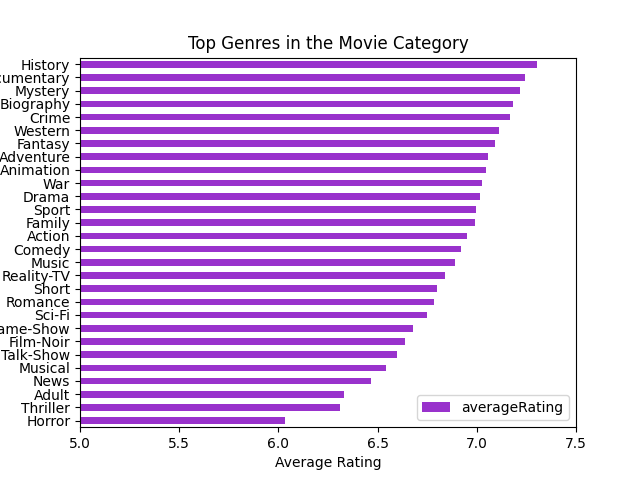

In [24]:
hbchart=top_genres4.select('genres','averageRating').sort(col('averageRating')).toPandas()
hbchart.plot.barh(x='genres', y='averageRating', color='darkorchid')
plt.xlim([5.0 ,7.5])
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Top Genres in the Movie Category')
plt.legend(loc=4)
%matplot plt

## PART 3 - Analyzing Job Categories

## Total Unique Job Categories

**What is the total number of unique job categories?**

In [25]:
movie_actors.select('tconst','category').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------+
|   tconst|       category|
+---------+---------------+
|tt0000001|           self|
|tt0000001|       director|
|tt0000001|cinematographer|
|tt0000002|       director|
|tt0000002|       composer|
+---------+---------------+
only showing top 5 rows

In [26]:
movie_actors.select(countDistinct('category')).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                      12|
+------------------------+

**What are the unique job categories available?**

In [27]:
movie_actors.select('category').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|production_designer|
|             writer|
|              actor|
|    cinematographer|
|      archive_sound|
|    archive_footage|
|               self|
|             editor|
|           composer|
|           director|
+-------------------+

## Top Job Categories

Now let's find the top job categories in this dataset by rolling up categories.

### Counts of Titles / Job Category

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [28]:
movie_actors.groupBy('category').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+
|           category|  count|
+-------------------+-------+
|            actress|6325097|
|           producer|2197866|
|production_designer| 285924|
|             writer|4811596|
|              actor|8493701|
|    cinematographer|1300404|
|      archive_sound|   2143|
|    archive_footage| 209035|
|               self|6153089|
|             editor|1197669|
|           composer|1313187|
|           director|4179106|
+-------------------+-------+

### Bar Chart of Top Job Categories

With this data available, let us now build a barchart of the top 5 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [29]:
movie_actors2 = movie_actors.groupBy('category').count().sort(col('count').desc())
movie_actors2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+
|           category|  count|
+-------------------+-------+
|              actor|8493701|
|            actress|6325097|
|               self|6153089|
|             writer|4811596|
|           director|4179106|
|           producer|2197866|
|           composer|1313187|
|    cinematographer|1300404|
|             editor|1197669|
|production_designer| 285924|
|    archive_footage| 209035|
|      archive_sound|   2143|
+-------------------+-------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

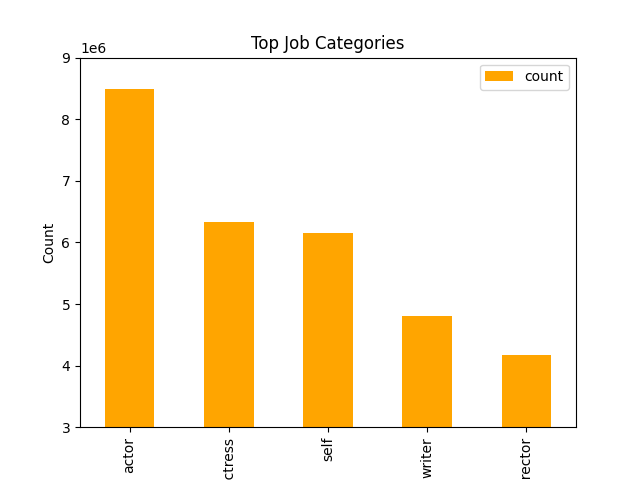

In [30]:
bctjc=movie_actors2.limit(5).toPandas()
bctjc.plot.bar(x='category', y='count', color='orange')
plt.ylim([3000000 , 9000000])
plt.xlabel('Job Categories')
plt.ylabel('Count')
plt.title('Top Job Categories')
plt.legend(loc=1)
%matplot plt

# PART 4 - Answer to the following questions:

## 1) Find all the "movies" featuring "Johnny Depp" and "Helena Bonham Carter".

First join actors, genres, and movie actors on each other

In [31]:
jd_hbc = actors.join(movie_actors).where(actors['nconst'] == movie_actors['nconst'])
jd_hbc2 = jd_hbc.join(genres).where(jd_hbc['tconst'] == genres['tconst']).select('primaryTitle', 'primaryName','titleType')
jd_hbc3 = jd_hbc2.select('primaryTitle','primaryName','titleType').filter("titleType =='movie'")
jd_hbc4 = jd_hbc3.select('primaryTitle','primaryName').filter("primaryName=='Johnny Depp' OR primaryName=='Helena Bonham Carter'")
jd_hbc4.groupBy('primaryTitle').count().where("count>1").drop('count').show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------+
|primaryTitle                                  |
+----------------------------------------------+
|Corpse Bride                                  |
|Dark Shadows                                  |
|Charlie and the Chocolate Factory             |
|Alice Through the Looking Glass               |
|Sweeney Todd: The Demon Barber of Fleet Street|
|Alice in Wonderland                           |
+----------------------------------------------+

## 2) Find all the "movies" featuring "Brad Pitt" after 2010.

In [32]:
nll = '\\N'
bp = actors.join(movie_actors).where(actors['nconst'] == movie_actors['nconst'])
bp2 = bp.join(genres).where(bp['tconst'] == genres['tconst']).select('primaryTitle', 'primaryName','titleType','startYear').filter((bp.primaryName=='Brad Pitt') & (genres.titleType =='movie') & (genres.startYear != nll) & (genres.startYear > '2010'))
bp2.select('primaryTitle','startYear').sort(col('startYear').desc()).show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------+---------+
|primaryTitle                     |startYear|
+---------------------------------+---------+
|Babylon                          |2021     |
|Kajillionaire                    |2020     |
|Irresistible                     |2020     |
|The King                         |2019     |
|Ad Astra                         |2019     |
|Once Upon a Time ... in Hollywood|2019     |
|Vice                             |2018     |
|War Machine                      |2017     |
|Allied                           |2016     |
|Voyage of Time: Life's Journey   |2016     |
|The Big Short                    |2015     |
|Hitting the Apex                 |2015     |
|By the Sea                       |2015     |
|Fury                             |2014     |
|World War Z                      |2013     |
|Kick-Ass 2                       |2013     |
|12 Years a Slave                 |2013     |
|Killing Them Softly              |2012     |
|The Tree of Life                 

## 3) What is the number of "movies" "acted" by "Zendaya" per year?

In [33]:
nll = '\\N'
zendaya = actors.join(movie_actors).where(actors['nconst'] == movie_actors['nconst'])
zendaya2 = zendaya.join(genres).where(zendaya['tconst'] == genres['tconst']).select('primaryTitle', 'primaryName','titleType','startYear').filter((zendaya.primaryName=='Zendaya') & (genres.titleType =='movie') & (genres.startYear != nll))
zendaya2.groupBy('startYear').count().show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|startYear|count|
+---------+-----+
|2020     |1    |
|2018     |2    |
|2017     |1    |
+---------+-----+

## 4) What are the "movies" by average rating greater than "9.7" and released in "2019"?

In [34]:
movies = genres.join(movie_ratings).where(genres['tconst'] == movie_ratings['tconst'])
movies2 = movies.select('primaryTitle', 'averageRating').filter((movies.titleType=='movie') & (movies.startYear == '2019') & (movies.averageRating > 9.7) )
movies3 = movies2.withColumn('averageRating', col('averageRating').cast('Float'))
movies3.sort(col('averageRating').desc()).show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------+-------------+
|primaryTitle                                     |averageRating|
+-------------------------------------------------+-------------+
|The Twilight Zone: A 60th Anniversary Celebration|10.0         |
|A Grunt's Life                                   |10.0         |
|The Butcher Baronet                              |10.0         |
|Bu Can Var Oldugu Sürece                         |10.0         |
|L'Enfant Terrible                                |10.0         |
|Our Scripted Life                                |10.0         |
|A Medicine for the Mind                          |10.0         |
|Love in Kilnerry                                 |10.0         |
|Kirket                                           |10.0         |
|Superhombre                                      |9.9          |
|Puritan: All of Life to The Glory of God         |9.9          |
|The Cardinal                                     |9.9          |
|Square On

## Extra Credit - Analysis of your choice

Try and analyze some interesting dimension to this data. You should specify the question in your Project2_Analysis.ipynb. 

You must join at least two datasets.


## Top 20 Movie Directors with the highest Weighted Average Ratings released in 2017-2022.

In [35]:
nll = '\\N'
actor = genres.join(movie_actors).where(genres['tconst'] == movie_actors['tconst'])
actor2 = actor.join(actors).where(actor['nconst'] == actors['nconst']).select('primaryName', genres['tconst'],'startYear','titleType','category')
actor3 = actor2.join(movie_ratings).where(actor2['tconst'] == movie_ratings['tconst']).select('primaryName','averageRating','startYear','titleType','numVotes','category')
actor4 = actor3.filter((genres.titleType=='movie')&(genres.startYear != nll)&(genres.startYear >= 2017)&(genres.startYear <=2022)&(movie_actors.category=='director'))
actor5 = actor4.withColumn('averageRating', col('averageRating').cast('Float')).withColumn('numVotes', col('numVotes').cast('Float')).withColumn('Weighted Score', col('averageRating') * col('numVotes'))
actor6 = actor5.groupby('primaryName').sum('Weighted Score').withColumnRenamed("sum(Weighted Score)","Weighted Score").sort(col('Weighted Score').desc()).show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----------------+
|primaryName      |Weighted Score   |
+-----------------+-----------------+
|Joe Russo        |1.1287869E7      |
|Anthony Russo    |1.1286742E7      |
|Jon Watts        |5174425.25       |
|David Leitch     |5025152.625      |
|James Mangold    |4872498.5        |
|Jordan Peele     |4410769.125      |
|Todd Phillips    |4108825.75       |
|Taika Waititi    |4096711.0        |
|Ryan Coogler     |4024088.5        |
|James Gunn       |3883387.25       |
|Chad Stahelski   |3872830.125      |
|Christopher Nolan|3851313.25       |
|Patty Jenkins    |3753087.75       |
|Andy Muschietti  |3746174.5        |
|Rian Johnson     |3439359.900390625|
|Steven Spielberg |3220537.5        |
|Denis Villeneuve |3199704.0        |
|Bryan Singer     |3140792.0        |
|Martin McDonagh  |3016148.5        |
|Edgar Wright     |2941025.25       |
+-----------------+-----------------+
only showing top 20 rows